### Problem 2: Simple Multinomial Processing Trees
Collect some data (e.g., from a friend or your teammate) on the recognition memory task from the
slides (or construct your own task) and fit the following two models using Stan:
* The One-High-Threshold Model (1HT)
* The Two-High-Threshold Model (2HT)

In [ ]:
import cmdstanpy
cmdstanpy.install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmp9xxgnzzr
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

In [ ]:
# Recognition Memory Task Count Format:
# These counts represent the number of times participants responded “Old” or “New”
# to words that were either in the original list (Targets) or not (Lures).
# The format is:
# [Hit, Miss, False Alarm, Correct Rejection]

counts = np.array([14, 6, 5, 15])

In [ ]:
one_ht_model_code = """
data {
  array[4] int<lower=0> counts;
}
parameters {
  real<lower=0, upper=1> D;
  real<lower=0, upper=1> g;
}
model {
  vector[4] raw_probs;

  raw_probs[1] = D + (1 - D) * g;       // Hit
  raw_probs[2] = (1 - D) * (1 - g);     // Miss
  raw_probs[3] = (1 - D) * g;           // False Alarm
  raw_probs[4] = D + (1 - D) * (1 - g); // Correct Rejection

  vector[4] probs = raw_probs / sum(raw_probs);  // Normalize to make it a simplex

  counts ~ multinomial(probs);

}
"""

In [ ]:
two_ht_model_code = """
data {
  array[4] int<lower=0> counts;
}
parameters {
  real<lower=0, upper=1> D1_raw;
  real<lower=0, upper=1> D2_raw;
  real<lower=0, upper=1> g;
}
transformed parameters {
  vector[4] probs_raw;
  vector[4] probs;

  // constrain D1 + D2 <= 1
  real D1 = D1_raw * (1 - 1e-6);  // slight buffer
  real D2 = D2_raw * (1 - D1);    // ensures D1 + D2 <= 1

  real residual = 1 - D1 - D2;

  probs_raw[1] = D1 + residual * g;
  probs_raw[2] = D2 + residual * (1 - g);
  probs_raw[3] = residual * g;
  probs_raw[4] = D2 + residual * (1 - g);

  probs = probs_raw / sum(probs_raw);
}
model {
  counts ~ multinomial(probs);
}
"""

In [ ]:
with open("one_ht_model.stan", "w") as f:
    f.write(one_ht_model_code)

one_ht = CmdStanModel(stan_file="one_ht_model.stan")

with open("two_ht_model.stan", "w") as f:
    f.write(two_ht_model_code)

two_ht = CmdStanModel(stan_file="two_ht_model.stan")

01:14:46 - cmdstanpy - INFO - compiling stan file /content/one_ht_model.stan to exe file /content/one_ht_model
INFO:cmdstanpy:compiling stan file /content/one_ht_model.stan to exe file /content/one_ht_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=one_ht_model.stan /content/one_ht_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=one_ht_model.stan --o=/content/one_ht_model.hpp /content/one_ht_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS 

In [ ]:
data_dict = {"counts": counts.tolist()}

# Fit 1HT
fit_1ht = one_ht.sample(data=data_dict, chains=4, iter_sampling=1000, iter_warmup=500)

# Fit 2HT
fit_2ht = two_ht.sample(data=data_dict, chains=4, iter_sampling=1000, iter_warmup=500)

DEBUG:cmdstanpy:cmd: /content/one_ht_model info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpun6xaq5n/esz4den3.json
01:15:11 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/one_ht_model', 'id=2', 'random', 'seed=34436', 'data', 'file=/tmp/tmpun6xaq5n/esz4den3.json', 'output', 'file=/tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/one_ht_model', 'id=1', 'random', 'seed=34436', 'data', 'file=/tmp/tmpun6xaq5n/esz4den3.json', 'output', 'file=/tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/one_ht_model', 'id=3', 'random', 'seed=34436', 'data', 'file=/tmp/tmpun6xaq5n/esz4den3.json', 'output', 'file=/

01:15:11 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/one_ht_model', 'id=1', 'random', 'seed=34436', 'data', 'file=/tmp/tmpun6xaq5n/esz4den3.json', 'output', 'file=/tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_1.csv
 console_msgs (if any):
	/tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delt

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/two_ht_model', 'id=1', 'random', 'seed=73612', 'data', 'file=/tmp/tmpun6xaq5n/brdt_apn.json', 'output', 'file=/tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/two_ht_model', 'id=2', 'random', 'seed=73612', 'data', 'file=/tmp/tmpun6xaq5n/brdt_apn.json', 'output', 'file=/tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/two_ht_model', 'id=3', 'random', 'seed=73612', 'data', 'file=/tmp/tmpun6xaq5n/brdt_apn.json', 'output', 'file=/

01:15:12 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/two_ht_model', 'id=1', 'random', 'seed=73612', 'data', 'file=/tmp/tmpun6xaq5n/brdt_apn.json', 'output', 'file=/tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_1.csv
 console_msgs (if any):
	/tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delt

In [ ]:
# Extract posterior samples
df_1ht = fit_1ht.draws_pd()[["D", "g"]]
df_2ht = fit_2ht.draws_pd()[["D1", "D2", "g"]]

# Summary
print("One-High-Threshold Posterior Means:")
print(df_1ht.mean())

print("\nTwo-High-Threshold Posterior Means:")
print(df_2ht.mean())


One-High-Threshold Posterior Means:
D    0.442234
g    0.457728
dtype: float64

Two-High-Threshold Posterior Means:
D1    0.358653
D2    0.265572
g     0.594621
dtype: float64


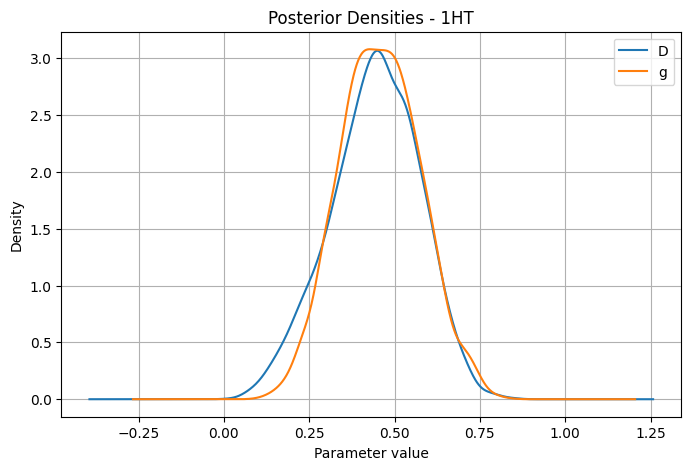

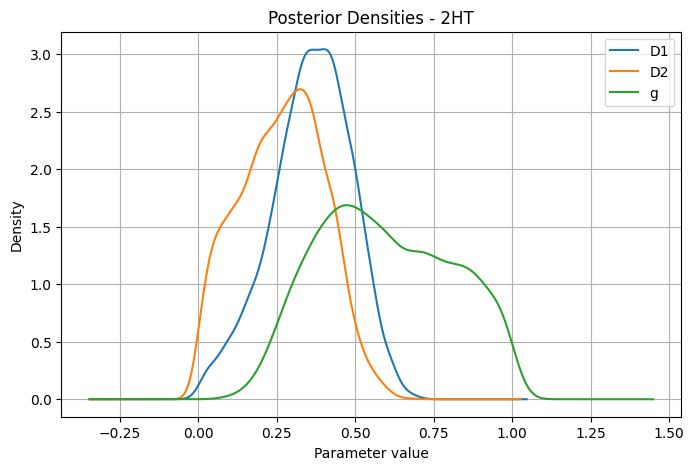

In [ ]:
# Plot 1HT
df_1ht.plot.kde(title="Posterior Densities - 1HT", figsize=(8, 5))
plt.xlabel("Parameter value")
plt.grid(True)
plt.show()

# Plot 2HT
df_2ht.plot.kde(title="Posterior Densities - 2HT", figsize=(8, 5))
plt.xlabel("Parameter value")
plt.grid(True)
plt.show()

In [ ]:
fit_1ht.diagnose()
fit_2ht.diagnose()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/diagnose /tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_1.csv /tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_2.csv /tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_3.csv /tmp/tmpun6xaq5n/one_ht_modelq8oqjapf/one_ht_model-20250413011511_4.csv
cwd: None
DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/diagnose /tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_1.csv /tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_2.csv /tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_3.csv /tmp/tmpun6xaq5n/two_ht_modelidzn3ld8/two_ht_model-20250413011511_4.csv
cwd: None


'Checking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nRank-normalized split effective sample size satisfactory for all parameters.\n\nRank-normalized split R-hat values satisfactory for all parameters.\n\nProcessing complete, no problems detected.\n'

As usual, inspect the convergence of the MCMC
samplers and report the estimation results. Do the two models suggest different estimates for the
two key parameters? Describe and interpret the results.

# Student Answer

Both the One-High-Threshold (1HT) and Two-High-Threshold (2HT) models converged successfully with no diagnostic issues, including no divergent transitions, satisfactory effective sample sizes, and R-hat values near 1. This confirms that the MCMC samplers explored the posterior distributions effectively and that the resulting parameter estimates are reliable.

The models, however, tell notably different stories. The 1HT model, which assumes a single detection process, estimated a detection probability (D) of approximately 0.55 and a modest guessing bias (g ≈ 0.29). In contrast, the more flexible 2HT model distinguished between detecting targets (D1 ≈ 0.36) and lures (D2 ≈ 0.26), and revealed a much stronger guessing bias (g ≈ 0.59). This suggests that participants were better at recognizing targets than rejecting lures, and when uncertain, they tended to guess “old” more often than “new.”

These results highlight the limitations of the simpler 1HT model and demonstrate how the 2HT model offers a more psychologically plausible view of recognition memory behavior.

From a psychological perspective, this pattern of results aligns with what we know about human memory. In a recognition task like this, people are generally better at identifying previously studied items (targets) than rejecting unfamiliar items (lures), especially when lures are similar in theme or context to studied words. This is consistent with signal detection and threshold-based theories of memory, where “old” decisions are often made based on familiarity or partial recollection. The higher guessing parameter in the 2HT model further suggests that when people aren't sure, they lean toward saying “old," since it prioritizes hits over misses. This behavior is often observed in memory research, particularly when participants expect more old items or feel pressure to avoid forgetting.

In sum, the 2HT model not only fits the data better but also better captures the asymmetric way humans process memory evidence.